In [2]:
import pandas as pd

file_path = "fhvhv_tripdata_2024-12.parquet"
df = pd.read_parquet(file_path, engine='pyarrow')  # Hoặc engine='fastparquet'
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21068851 entries, 0 to 21068850
Data columns (total 24 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   dispatching_base_num  object        
 2   originating_base_num  object        
 3   request_datetime      datetime64[us]
 4   on_scene_datetime     datetime64[us]
 5   pickup_datetime       datetime64[us]
 6   dropoff_datetime      datetime64[us]
 7   PULocationID          int32         
 8   DOLocationID          int32         
 9   trip_miles            float64       
 10  trip_time             int64         
 11  base_passenger_fare   float64       
 12  tolls                 float64       
 13  bcf                   float64       
 14  sales_tax             float64       
 15  congestion_surcharge  float64       
 16  airport_fee           float64       
 17  tips                  float64       
 18  driver_pay            float64       
 19

C:\Users\AD\AppData\Local\Temp\ipykernel_3216\984584147.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pickup_hour', y='trip_count', data=trips_by_hour_pd, palette="Blues")


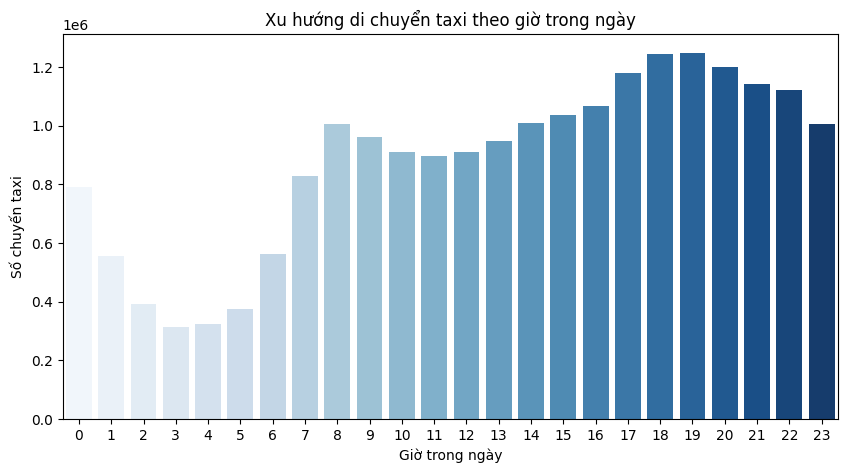

C:\Users\AD\AppData\Local\Temp\ipykernel_3216\984584147.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pickup_day', y='trip_count', data=trips_by_day_pd, palette="Greens")


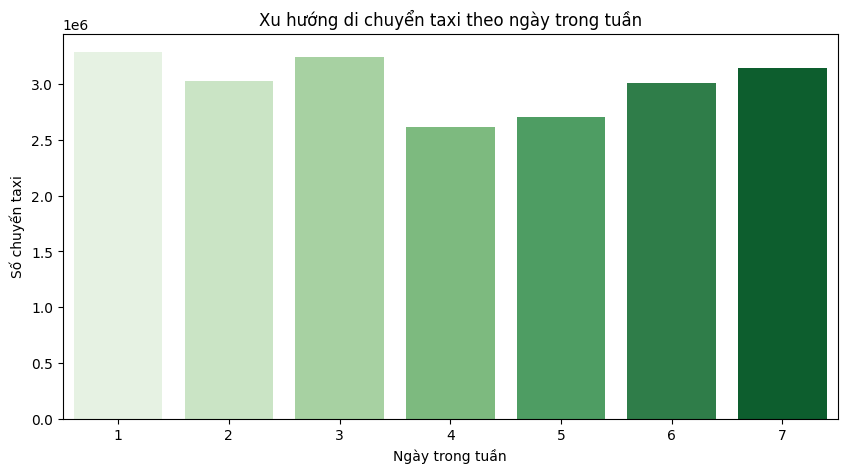

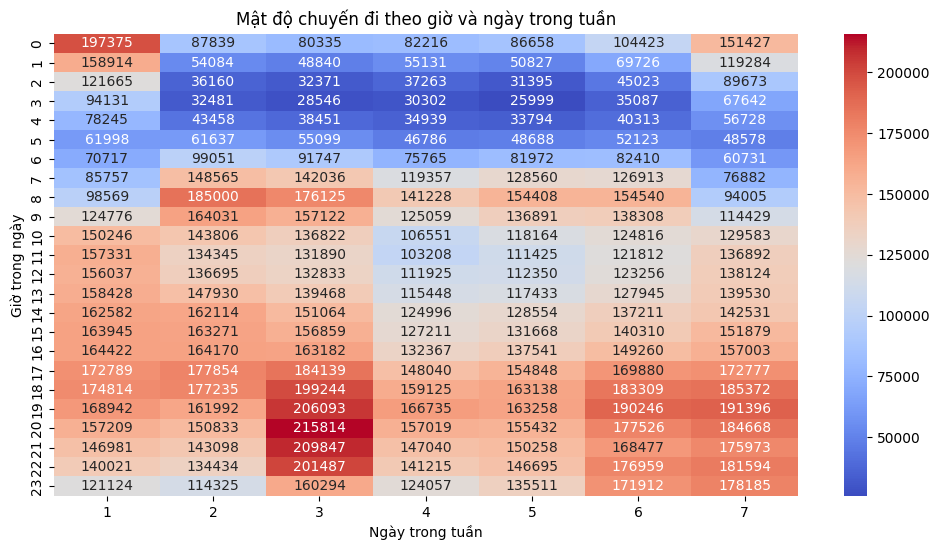

C:\Users\AD\AppData\Local\Temp\ipykernel_3216\984584147.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PULocationID', y='trip_count', data=popular_pickups_pd, palette="Oranges")


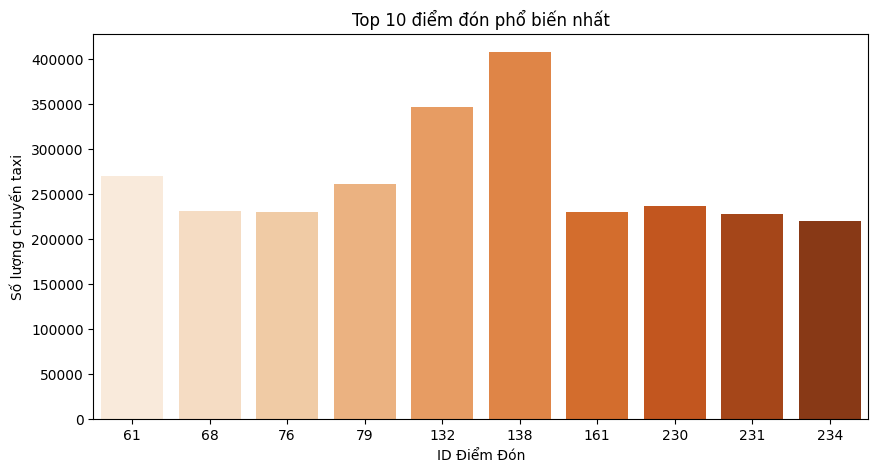

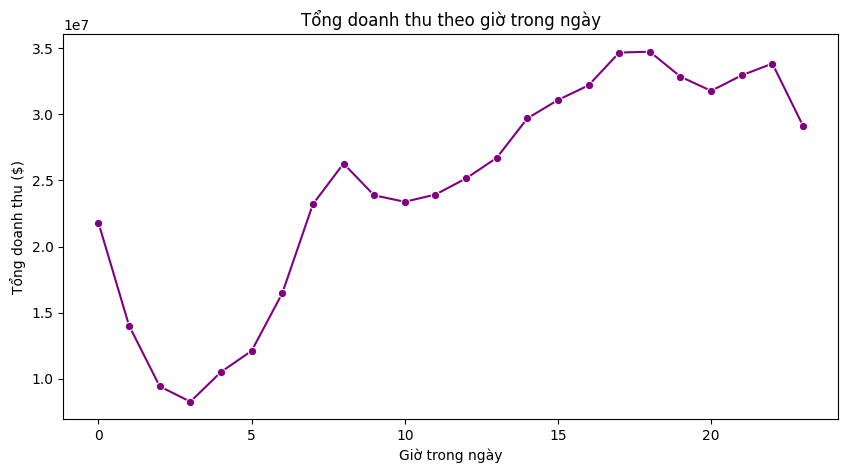

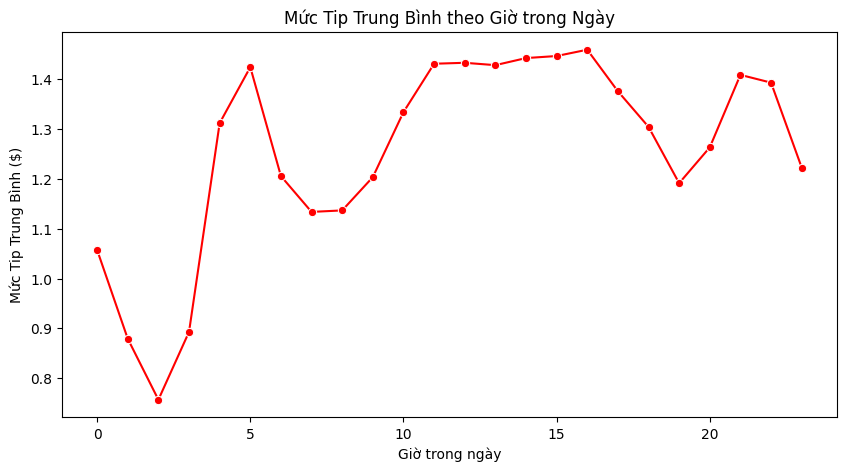

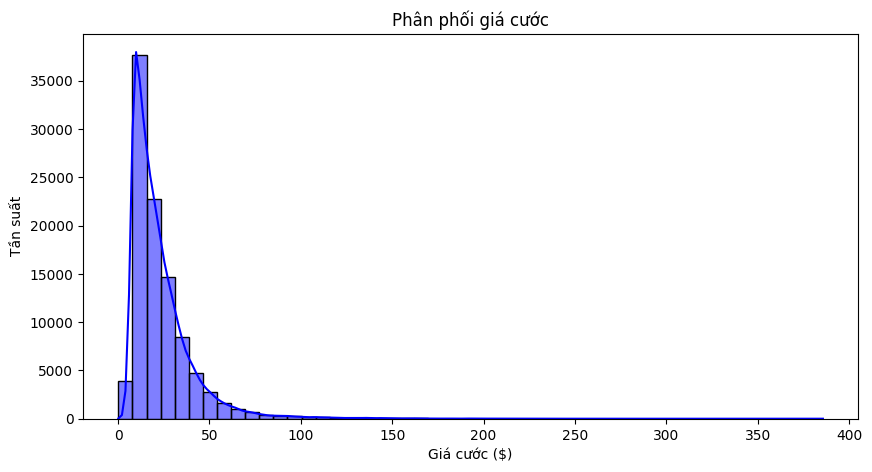

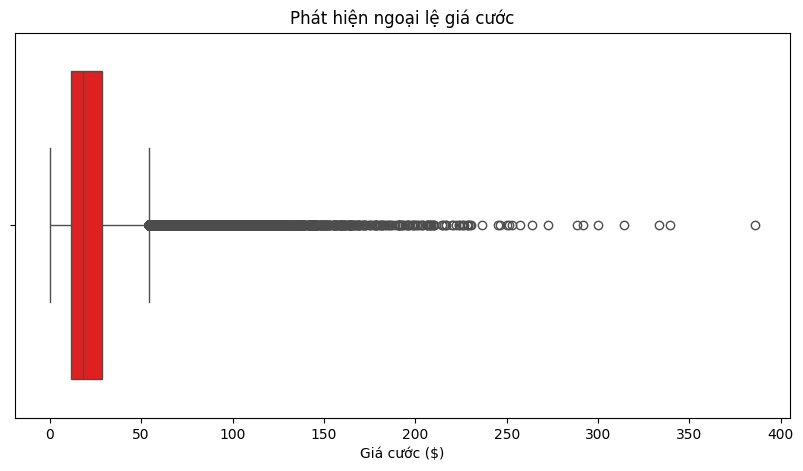

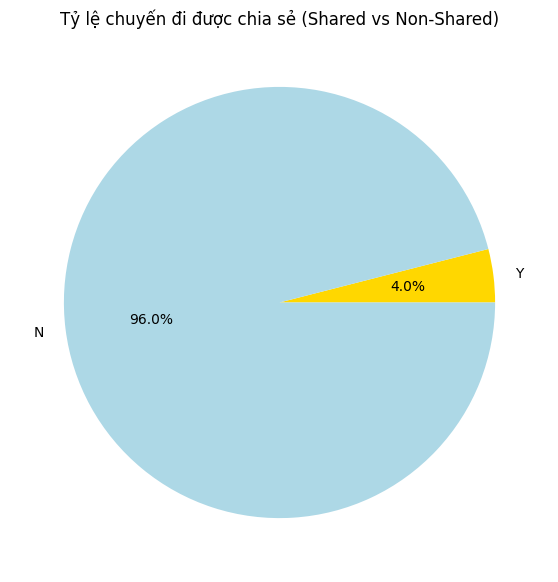

C:\Users\AD\AppData\Local\Temp\ipykernel_3216\984584147.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='pickup_hour', y='tips', data=tip_by_hour_pd, palette='coolwarm')


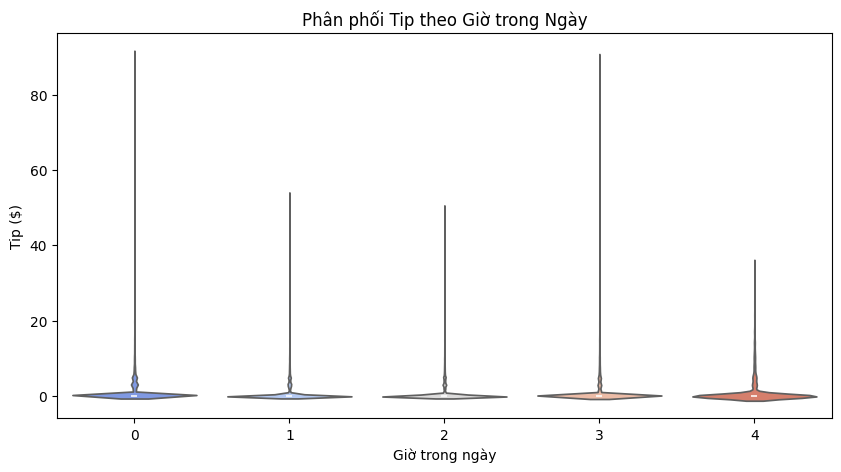

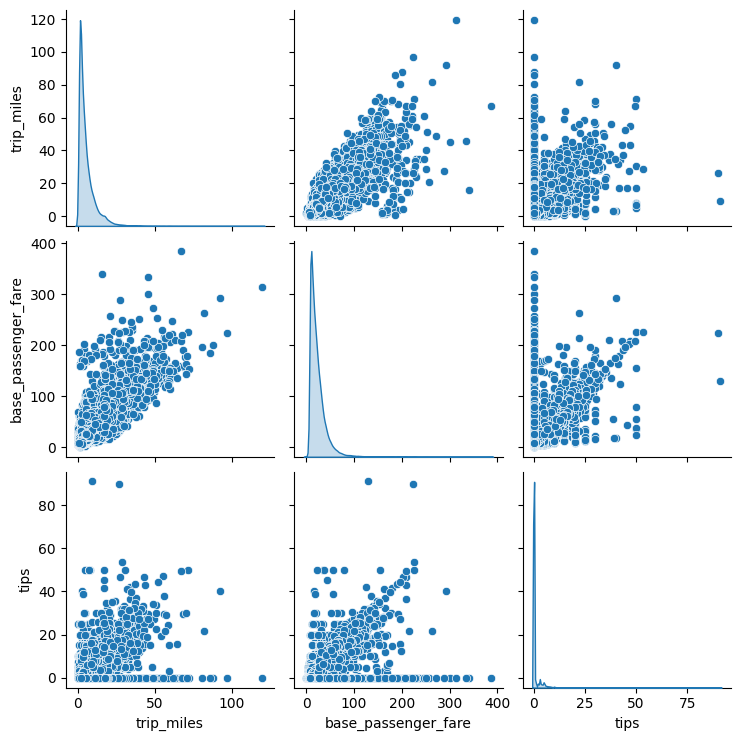

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, dayofweek, month, year, avg, count, sum
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Khởi tạo SparkSessionc
spark = SparkSession.builder \
    .appName("NYC_Taxi_Analysis") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

# Đọc dữ liệu từ file Parquet
df = spark.read.parquet("fhvhv_tripdata_2024-12.parquet")

# Tiền xử lý dữ liệu
df_clean = df.filter((col("trip_miles") > 0) & (col("base_passenger_fare") > 0) & (col("driver_pay") > 0))
df_clean = df_clean.filter(col("dropoff_datetime") > col("pickup_datetime"))

# Chuyển đổi định dạng thời gian
df_clean = df_clean.withColumn("pickup_hour", hour(col("pickup_datetime")))
df_clean = df_clean.withColumn("pickup_day", dayofweek(col("pickup_datetime")))
df_clean = df_clean.withColumn("pickup_month", month(col("pickup_datetime")))
df_clean = df_clean.withColumn("pickup_year", year(col("pickup_datetime")))

# ✅ Phân tích số lượng chuyến theo ngày & giờ
trips_by_hour = df_clean.groupBy("pickup_hour").agg(count("hvfhs_license_num").alias("trip_count")).orderBy("pickup_hour")
trips_by_hour_pd = trips_by_hour.toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(x='pickup_hour', y='trip_count', data=trips_by_hour_pd, palette="Blues")
plt.xlabel("Giờ trong ngày")
plt.ylabel("Số chuyến taxi")
plt.title("Xu hướng di chuyển taxi theo giờ trong ngày")
plt.show()

trips_by_day = df_clean.groupBy("pickup_day").agg(count("hvfhs_license_num").alias("trip_count")).orderBy("pickup_day")
trips_by_day_pd = trips_by_day.toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(x='pickup_day', y='trip_count', data=trips_by_day_pd, palette="Greens")
plt.xlabel("Ngày trong tuần")
plt.ylabel("Số chuyến taxi")
plt.title("Xu hướng di chuyển taxi theo ngày trong tuần")
plt.show()

# ✅ Heatmap - Mối quan hệ giữa giờ và ngày
heatmap_data = df_clean.groupBy("pickup_hour", "pickup_day").agg(count("hvfhs_license_num").alias("trip_count")).toPandas()
heatmap_pivot = heatmap_data.pivot(index="pickup_hour", columns="pickup_day", values="trip_count")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap="coolwarm", annot=True, fmt=".0f")
plt.xlabel("Ngày trong tuần")
plt.ylabel("Giờ trong ngày")
plt.title("Mật độ chuyến đi theo giờ và ngày trong tuần")
plt.show()

# ✅ Top điểm đón phổ biến
popular_pickups = df_clean.groupBy("PULocationID").agg(count("hvfhs_license_num").alias("trip_count")).orderBy(col("trip_count").desc()).limit(10)
popular_pickups_pd = popular_pickups.toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(x='PULocationID', y='trip_count', data=popular_pickups_pd, palette="Oranges")
plt.xlabel("ID Điểm Đón")
plt.ylabel("Số lượng chuyến taxi")
plt.title("Top 10 điểm đón phổ biến nhất")
plt.show()

# ✅ Tổng doanh thu theo giờ
revenue_by_hour = df_clean.groupBy("pickup_hour").agg(sum("base_passenger_fare").alias("total_revenue")).orderBy("pickup_hour")
revenue_by_hour_pd = revenue_by_hour.toPandas()

plt.figure(figsize=(10, 5))
sns.lineplot(x='pickup_hour', y='total_revenue', data=revenue_by_hour_pd, marker='o', color='purple')
plt.xlabel("Giờ trong ngày")
plt.ylabel("Tổng doanh thu ($)")
plt.title("Tổng doanh thu theo giờ trong ngày")
plt.show()

# ✅ Phân tích thói quen tip của khách
avg_tip_by_hour = df_clean.groupBy("pickup_hour").agg(avg("tips").alias("avg_tip")).orderBy("pickup_hour")
avg_tip_by_hour_pd = avg_tip_by_hour.toPandas()

plt.figure(figsize=(10, 5))
sns.lineplot(x='pickup_hour', y='avg_tip', data=avg_tip_by_hour_pd, marker='o', color='red')
plt.xlabel("Giờ trong ngày")
plt.ylabel("Mức Tip Trung Bình ($)")
plt.title("Mức Tip Trung Bình theo Giờ trong Ngày")
plt.show()

# ✅ Histogram - Phân phối giá cước
fare_distribution_pd = df_clean.select("base_passenger_fare").limit(100000).toPandas()
plt.figure(figsize=(10, 5))
sns.histplot(fare_distribution_pd['base_passenger_fare'], bins=50, kde=True, color='blue')
plt.xlabel("Giá cước ($)")
plt.ylabel("Tần suất")
plt.title("Phân phối giá cước")
plt.show()

# ✅ Boxplot - Phát hiện giá trị ngoại lệ
plt.figure(figsize=(10, 5))
sns.boxplot(x=fare_distribution_pd['base_passenger_fare'], color='red')
plt.xlabel("Giá cước ($)")
plt.title("Phát hiện ngoại lệ giá cước")
plt.show()

# ✅ Pie Chart - Tỷ lệ chuyến đi chia sẻ
payment_type_counts = df_clean.groupBy("shared_request_flag").count().toPandas()
plt.figure(figsize=(7, 7))
plt.pie(payment_type_counts['count'], labels=payment_type_counts['shared_request_flag'], autopct='%1.1f%%', colors=["gold", "lightblue"])
plt.title("Tỷ lệ chuyến đi được chia sẻ (Shared vs Non-Shared)")
plt.show()

# ✅ Violin Plot - Phân phối tip theo giờ
tip_by_hour_pd = df_clean.select("pickup_hour", "tips").limit(100000).toPandas()
plt.figure(figsize=(10, 5))
sns.violinplot(x='pickup_hour', y='tips', data=tip_by_hour_pd, palette='coolwarm')
plt.xlabel("Giờ trong ngày")
plt.ylabel("Tip ($)")
plt.title("Phân phối Tip theo Giờ trong Ngày")
plt.show()

# ✅ Pairplot - Mối quan hệ giữa khoảng cách, giá cước và tip
pairplot_pd = df_clean.select("trip_miles", "base_passenger_fare", "tips").limit(100000).toPandas()
sns.pairplot(pairplot_pd, diag_kind='kde', markers="o")
plt.show()

# Kết thúc Spark Session
spark.stop()


In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import when

# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("NYC_Taxi_Analysis") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

# Đọc dữ liệu từ file Parquet
df = spark.read.parquet("fhvhv_tripdata_2024-12.parquet")

# Tiền xử lý dữ liệu
df_clean = df.filter((col("trip_miles") > 0) & (col("base_passenger_fare") > 0) & (col("driver_pay") > 0))
df_clean = df_clean.filter(col("dropoff_datetime") > col("pickup_datetime")),

# Chuyển đổi định dạng thời gian
df_clean = df_clean.withColumn("pickup_hour", hour(col("pickup_datetime")))
df_clean = df_clean.withColumn("pickup_day", dayofweek(col("pickup_datetime")))
df_clean = df_clean.withColumn("pickup_month", month(col("pickup_datetime")))
df_clean = df_clean.withColumn("pickup_year", year(col("pickup_datetime")))

# Chọn các cột quan trọng
df_ml = df_clean.select("trip_miles", "pickup_hour", "pickup_day", "base_passenger_fare", "tips")

# Loại bỏ các dòng có giá trị NULL
df_ml = df_ml.dropna()

# Chuẩn bị dữ liệu cho mô hình bằng VectorAssembler
feature_cols = ["trip_miles", "pickup_hour", "pickup_day"]
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_ml = vector_assembler.transform(df_ml)

# Chuẩn hóa dữ liệu
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
df_ml = scaler.fit(df_ml).transform(df_ml)

# Hiển thị dữ liệu đã chuẩn bị
df_ml.select("scaled_features", "base_passenger_fare").show(5, truncate=False)


+---------------------------------------------+-------------------+
|scaled_features                              |base_passenger_fare|
+---------------------------------------------+-------------------+
|[1.0214622831290696,0.0,0.48900162340620973] |14.0               |
|[0.30013745656876883,0.0,0.48900162340620973]|10.74              |
|[0.24209982684552622,0.0,0.48900162340620973]|11.13              |
|[0.30345389255295413,0.0,0.48900162340620973]|12.01              |
|[1.5404845146540675,0.0,0.48900162340620973] |41.65              |
+---------------------------------------------+-------------------+
only showing top 5 rows



In [5]:
# Chia tập dữ liệu thành train và test
train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=42)

# Huấn luyện mô hình hồi quy tuyến tính
lr = LinearRegression(featuresCol="scaled_features", labelCol="base_passenger_fare")
lr_model = lr.fit(train_data)

# Dự đoán trên tập test
predictions = lr_model.transform(test_data)

# Đánh giá mô hình
evaluator = RegressionEvaluator(labelCol="base_passenger_fare", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"🔹 RMSE (Root Mean Squared Error): {rmse}")

# Hiển thị một số kết quả dự đoán
predictions.select("prediction", "base_passenger_fare", "scaled_features").show(10)


🔹 RMSE (Root Mean Squared Error): 15.217544291468844
+-----------------+-------------------+--------------------+
|       prediction|base_passenger_fare|     scaled_features|
+-----------------+-------------------+--------------------+
| 8.99851629813821|               7.37|[0.00116075259446...|
|7.380195772206473|               4.73|[0.00165821799209...|
|6.742837137170948|               8.02|[0.00165821799209...|
|7.167736165384704|               7.19|[0.00165821799209...|
|8.229993828633985|               9.78|[0.00165821799209...|
|8.371623473800273|               6.08|[0.00165821799209...|
|8.513253118966562|               9.77|[0.00165821799209...|
|9.292241399168374|               7.19|[0.00165821799209...|
|9.363051175394073|              16.32|[0.00165821799209...|
|9.292231306453484|              10.91|[0.00165821799209...|
+-----------------+-------------------+--------------------+
only showing top 10 rows



In [6]:
# Huấn luyện mô hình hồi quy tuyến tính cho Tip
lr_tip = LinearRegression(featuresCol="scaled_features", labelCol="tips")
lr_tip_model = lr_tip.fit(train_data)

# Dự đoán trên tập test
predictions_tip = lr_tip_model.transform(test_data)

# Đánh giá mô hình
rmse_tip = evaluator.evaluate(predictions_tip)
print(f"🔹 RMSE cho Tip Prediction: {rmse_tip}")

# Hiển thị một số kết quả dự đoán
predictions_tip.select("prediction", "tips", "scaled_features").show(10)


🔹 RMSE cho Tip Prediction: 36.56047023275145
+--------------------+----+--------------------+
|          prediction|tips|     scaled_features|
+--------------------+----+--------------------+
|  0.1784343407233883| 0.0|[0.00116075259446...|
|0.011467493066376427| 0.0|[0.00165821799209...|
|-0.01802511432401884| 0.0|[0.00165821799209...|
| 0.02291059095850427| 0.0|[0.00165821799209...|
| 0.09333890363142264| 0.0|[0.00165821799209...|
|  0.1176211222367268| 0.0|[0.00165821799209...|
| 0.14190334084203096| 0.0|[0.00165821799209...|
|  0.1956781668377304| 0.0|[0.00165821799209...|
| 0.22377475140707717| 0.0|[0.00165821799209...|
| 0.22758911737111978| 0.0|[0.00165821799209...|
+--------------------+----+--------------------+
only showing top 10 rows

